In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt # basic visualisation library
%matplotlib inline
import seaborn as sns # advanced and nice visualisations
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS # library to create a wordcloud

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier

import warnings # library to manage wornings
warnings.simplefilter(action='ignore', category=FutureWarning) # silencing FutureWarnings out

#from google.colab import drive
#drive.mount('/content/gdrive')

print("numpy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("seaborn version: {}".format(sns.__version__))

numpy version: 1.18.4
pandas version: 1.0.3
seaborn version: 0.10.1


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hryang06/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/nlp/train.csv')
#test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/nlp/test.csv')
#train = pd.read_csv('C:\Users\heerin\Desktop\github\NLP-with-Disaster-Tweets/train.csv')
#test = pd.read_csv('C:\Users\heerin\Desktop\github\NLP-with-Disaster-Tweets/test.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train_without_label = train.drop('target', axis=1)
traintest = pd.concat([train_without_label,test])

print("[shape] train, test, train + test\n")
print(train.shape, test.shape, traintest.shape)

[shape] train, test, train + test

(7613, 5) (3263, 4) (10876, 4)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## EDA, Exploratory Data Analysis


In [6]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


<function matplotlib.pyplot.show(*args, **kw)>

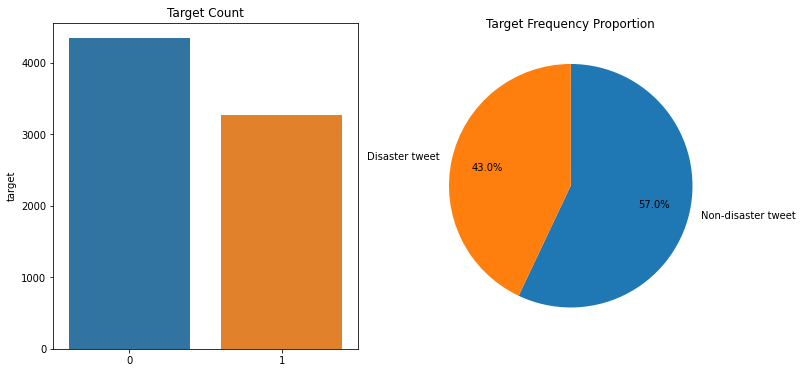

In [7]:
# Target Distribution (0 or 1)
dist_class = train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Target Frequency Proportion")
plt.show

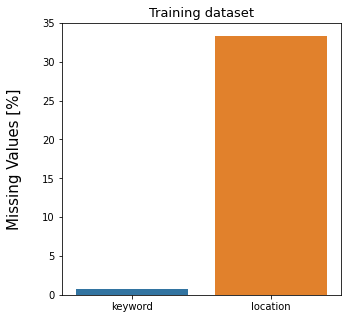

In [8]:
missing_cols = ['keyword', 'location']

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
train_nans = train[missing_cols].isnull().sum()/len(train)*100  # calculating percent of missing data in each column

sns.barplot(x=train_nans.index, y=train_nans.values, ax=ax)  # creating a barplot

ax.set_ylabel('Missing Values [%]', size=15, labelpad=20)
ax.set_yticks(np.arange(0,40,5))
ax.set_ylim((0,35))

ax.set_title('Training dataset', fontsize=13)
plt.show()

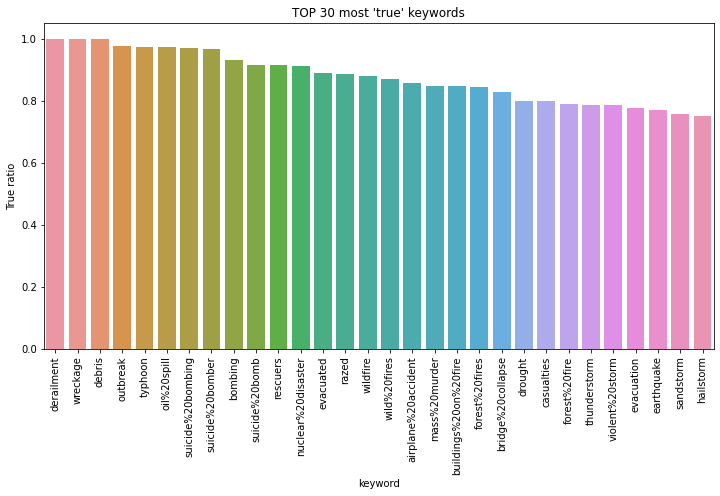

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
true_ratios = train.groupby('keyword')['target'].mean().sort_values(ascending=False)
sns.barplot(x=true_ratios.index[:30], y=true_ratios.values[:30], ax=ax)
plt.xticks(rotation=90)
plt.title("TOP 30 most 'true' keywords")
plt.ylabel("True ratio")
plt.show()

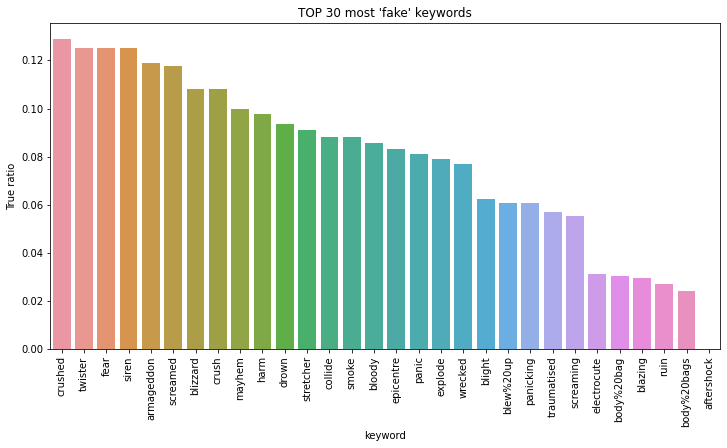

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
true_ratios = train.groupby('keyword')['target'].mean().sort_values(ascending=False)
sns.barplot(x=true_ratios.index[-30:], y=true_ratios.values[-30:], ax=ax)
plt.xticks(rotation=90)
plt.title("TOP 30 most 'fake' keywords")
plt.ylabel("True ratio")
plt.show()

### stopword 불용어

<https://wikidocs.net/22530>

 갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업이 필요하다. 여기서 큰 의미가 없다라는 것은 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어들을 말한다. 예를 들면, I, my, me, over, 조사, 접미사 같은 단어들은 문장에서는 자주 등장하지만 실제 의미 분석을 하는데는 거의 기여하는 바가 없다. 이러한 단어들을 불용어(stopword)라고 하며, NLTK에서는 위와 같은 100여개 이상의 영어 단어들을 불용어로 패키지 내에서 미리 정의하고 있다.

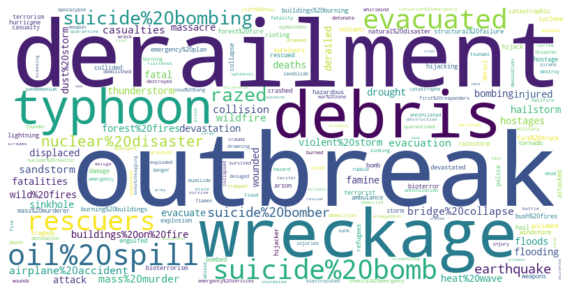

In [11]:
disaster_tweet = dict(train[train['target']==1]['keyword'].value_counts())

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(disaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

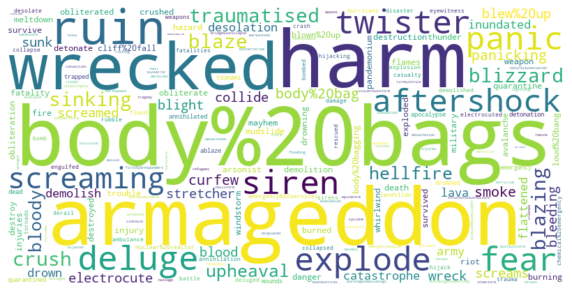

In [12]:
nondisaster_tweet = dict(train[train['target']==0]['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(nondisaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

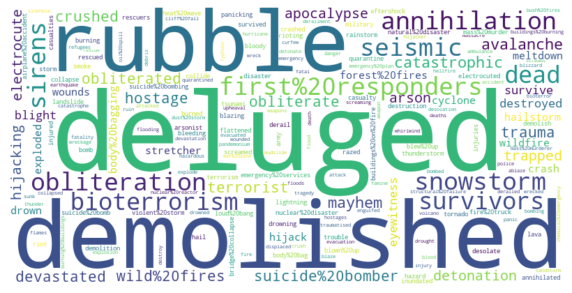

In [13]:
test_tweet = dict(test['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(test_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Data cleaning

Tokenization and Features Engineering...?

In [14]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

import string
def remove_punc(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [15]:
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text

In [16]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text

In [17]:
for datas in [train, test]:
    datas['cleaned_text'] = datas['text'].apply(lambda x : remove_url(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_html(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_emoji(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : unslang(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_punc(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : tokenization(x.lower()))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_stopwords(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : stemming(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : ' '.join(x))

In [18]:
train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order califor...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfir updat california hwi 20 close direct ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disast heavi rain caus flash flood stree...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im top hill see fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there emerg evacu happen build across street
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid tornado come area


In [19]:
test.head(10)

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,shakingit earthquak
6,21,NaN,NaN,They'd probably still show more life than Arse...,theyd probabl still show life arsen yesterday ...
7,22,NaN,NaN,Hey! How are you?,hey
8,27,NaN,NaN,What a nice hat?,nice hat
9,29,NaN,NaN,Fuck off!,fuck


## modeling : XGBoost

scikit-learn의 문서 전처리 함수 중 하나로, CountVectorizer()는 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW(Bag of Words) 인코딩한 벡터를 만든다.

In [20]:
vectorizer = CountVectorizer(analyzer='word', binary=True)
vectorizer.fit(train['cleaned_text'])

CountVectorizer(binary=True)

In [21]:
# df_train_feature = df_train[['keyword', 'location', 'cleaned_text']]
# X = vectorizer.transform(df_train_feature).todense()
X = vectorizer.transform(train['cleaned_text']).todense()
y = train['target'].values

print(X.shape)
print(y.shape)

(7613, 14633)
(7613,)


여기서 word2vec 가능할까

In [ ]:
# word2vec
from gensim.models import Word2Vec

print("gensim version: {}".format(gensim.__version__))

In [ ]:
"""
documents = []
for sentence in train['text']:
    text = sentence.split()
    documents.append(text)

model = Word2Vec(documents, size=150, window=10, min_count=2, workers=10, iter=10)
"""

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
print(X_train.shape)
print(X_valid.shape)

X_train

(5329, 14633)
(2284, 14633)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

About how to tune the hyperparameters of XGBClassifier, I used 'Complete Guide to Parameter Tuning in XGBoost with codes in Python' as reference.
Actually I'd like to use GridSearchCV, however I gave up using it due to kernel memory issues.

In [29]:
xgb_classifier = XGBClassifier(tree_method='gpu_hist',
                              learning_rate=0.1,
                              num_round=1000,
                              max_depth=10,
                              min_child_weight=2,
                              colsample_bytree=0.8,
                              subsample=0.9,
                              gamma=0.4,
                              reg_alpha=1e-5,
                              reg_lambda=1,
                              n_estimators=2000,
                              objective='binary:logistic',
                              eval_metric=["auc", "logloss", "error"],
                              early_stopping_rounds=50)

# https://www.coursera.org/learn/competitive-data-science/lecture/wzi5a/hyperparameter-tuning-ii

In [30]:
%%time
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

[17:41:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62157	validation_0-logloss:0.68012	validation_0-error:0.33590	validation_1-auc:0.61358	validation_1-logloss:0.68066	validation_1-error:0.33275
[1]	validation_0-auc:0.63635	validation_0-logloss:0.66852	validation_0-error:0.32276	validation_1-auc:0.62754	validation_1-logloss:0.66969	validation_1-error:0.32005
[2]	validation_0-auc:0.66047	validation_0-logloss:0.65826	validation_0-error:0.31282	validation_1-auc:0.66004	validation_1-logloss:0.65975	validation_1-error:0.30911
[3]	validation_0-auc:0.67349	validation_0-logloss:0.64983	validation_0-error:0.31282	validation_1-auc:0.66907	validation_1-logloss:0.65204	val

[47]	validation_0-auc:0.84825	validation_0-logloss:0.52047	validation_0-error:0.22706	validation_1-auc:0.81499	validation_1-logloss:0.53604	validation_1-error:0.24168
[48]	validation_0-auc:0.84979	validation_0-logloss:0.51900	validation_0-error:0.22687	validation_1-auc:0.81605	validation_1-logloss:0.53477	validation_1-error:0.23949
[49]	validation_0-auc:0.85033	validation_0-logloss:0.51742	validation_0-error:0.22593	validation_1-auc:0.81825	validation_1-logloss:0.53386	validation_1-error:0.23993
[50]	validation_0-auc:0.85082	validation_0-logloss:0.51604	validation_0-error:0.22481	validation_1-auc:0.81859	validation_1-logloss:0.53277	validation_1-error:0.23862
[51]	validation_0-auc:0.85156	validation_0-logloss:0.51461	validation_0-error:0.22387	validation_1-auc:0.81827	validation_1-logloss:0.53173	validation_1-error:0.23818
[52]	validation_0-auc:0.85245	validation_0-logloss:0.51322	validation_0-error:0.22406	validation_1-auc:0.81827	validation_1-logloss:0.53038	validation_1-error:0.2333

[97]	validation_0-auc:0.87779	validation_0-logloss:0.46658	validation_0-error:0.19535	validation_1-auc:0.83539	validation_1-logloss:0.49660	validation_1-error:0.22504
[98]	validation_0-auc:0.87791	validation_0-logloss:0.46578	validation_0-error:0.19516	validation_1-auc:0.83522	validation_1-logloss:0.49621	validation_1-error:0.22373
[99]	validation_0-auc:0.87812	validation_0-logloss:0.46504	validation_0-error:0.19460	validation_1-auc:0.83578	validation_1-logloss:0.49536	validation_1-error:0.22285
[100]	validation_0-auc:0.87829	validation_0-logloss:0.46426	validation_0-error:0.19516	validation_1-auc:0.83575	validation_1-logloss:0.49481	validation_1-error:0.22329
[101]	validation_0-auc:0.87885	validation_0-logloss:0.46353	validation_0-error:0.19516	validation_1-auc:0.83574	validation_1-logloss:0.49454	validation_1-error:0.22329
[102]	validation_0-auc:0.87919	validation_0-logloss:0.46280	validation_0-error:0.19478	validation_1-auc:0.83545	validation_1-logloss:0.49416	validation_1-error:0.2

[146]	validation_0-auc:0.89192	validation_0-logloss:0.43525	validation_0-error:0.18240	validation_1-auc:0.84046	validation_1-logloss:0.47966	validation_1-error:0.21541
[147]	validation_0-auc:0.89231	validation_0-logloss:0.43477	validation_0-error:0.18221	validation_1-auc:0.84041	validation_1-logloss:0.47936	validation_1-error:0.21454
[148]	validation_0-auc:0.89245	validation_0-logloss:0.43424	validation_0-error:0.18296	validation_1-auc:0.84052	validation_1-logloss:0.47883	validation_1-error:0.21454
[149]	validation_0-auc:0.89272	validation_0-logloss:0.43375	validation_0-error:0.18296	validation_1-auc:0.84070	validation_1-logloss:0.47853	validation_1-error:0.21410
[150]	validation_0-auc:0.89291	validation_0-logloss:0.43327	validation_0-error:0.18277	validation_1-auc:0.84122	validation_1-logloss:0.47836	validation_1-error:0.21454
[151]	validation_0-auc:0.89315	validation_0-logloss:0.43280	validation_0-error:0.18146	validation_1-auc:0.84098	validation_1-logloss:0.47843	validation_1-error:

[195]	validation_0-auc:0.90242	validation_0-logloss:0.41364	validation_0-error:0.17508	validation_1-auc:0.84451	validation_1-logloss:0.46896	validation_1-error:0.20797
[196]	validation_0-auc:0.90260	validation_0-logloss:0.41328	validation_0-error:0.17508	validation_1-auc:0.84455	validation_1-logloss:0.46887	validation_1-error:0.20797
[197]	validation_0-auc:0.90280	validation_0-logloss:0.41291	validation_0-error:0.17470	validation_1-auc:0.84461	validation_1-logloss:0.46873	validation_1-error:0.20797
[198]	validation_0-auc:0.90282	validation_0-logloss:0.41254	validation_0-error:0.17470	validation_1-auc:0.84456	validation_1-logloss:0.46865	validation_1-error:0.20797
[199]	validation_0-auc:0.90297	validation_0-logloss:0.41222	validation_0-error:0.17470	validation_1-auc:0.84475	validation_1-logloss:0.46842	validation_1-error:0.20841
[200]	validation_0-auc:0.90315	validation_0-logloss:0.41181	validation_0-error:0.17433	validation_1-auc:0.84486	validation_1-logloss:0.46832	validation_1-error:

[244]	validation_0-auc:0.90808	validation_0-logloss:0.39780	validation_0-error:0.16870	validation_1-auc:0.84893	validation_1-logloss:0.46136	validation_1-error:0.20841
[245]	validation_0-auc:0.90818	validation_0-logloss:0.39752	validation_0-error:0.16870	validation_1-auc:0.84879	validation_1-logloss:0.46135	validation_1-error:0.20753
[246]	validation_0-auc:0.90830	validation_0-logloss:0.39727	validation_0-error:0.16870	validation_1-auc:0.84862	validation_1-logloss:0.46150	validation_1-error:0.20753
[247]	validation_0-auc:0.90843	validation_0-logloss:0.39696	validation_0-error:0.16870	validation_1-auc:0.84879	validation_1-logloss:0.46130	validation_1-error:0.20709
[248]	validation_0-auc:0.90855	validation_0-logloss:0.39669	validation_0-error:0.16870	validation_1-auc:0.84894	validation_1-logloss:0.46106	validation_1-error:0.20709
[249]	validation_0-auc:0.90861	validation_0-logloss:0.39637	validation_0-error:0.16908	validation_1-auc:0.84882	validation_1-logloss:0.46102	validation_1-error:

[293]	validation_0-auc:0.91233	validation_0-logloss:0.38566	validation_0-error:0.16438	validation_1-auc:0.85148	validation_1-logloss:0.45629	validation_1-error:0.20272
[294]	validation_0-auc:0.91246	validation_0-logloss:0.38542	validation_0-error:0.16476	validation_1-auc:0.85169	validation_1-logloss:0.45604	validation_1-error:0.20315
[295]	validation_0-auc:0.91244	validation_0-logloss:0.38522	validation_0-error:0.16476	validation_1-auc:0.85191	validation_1-logloss:0.45573	validation_1-error:0.20272
[296]	validation_0-auc:0.91252	validation_0-logloss:0.38502	validation_0-error:0.16438	validation_1-auc:0.85189	validation_1-logloss:0.45572	validation_1-error:0.20184
[297]	validation_0-auc:0.91264	validation_0-logloss:0.38482	validation_0-error:0.16457	validation_1-auc:0.85185	validation_1-logloss:0.45577	validation_1-error:0.20184
[298]	validation_0-auc:0.91275	validation_0-logloss:0.38464	validation_0-error:0.16457	validation_1-auc:0.85186	validation_1-logloss:0.45577	validation_1-error:

[342]	validation_0-auc:0.91569	validation_0-logloss:0.37600	validation_0-error:0.16082	validation_1-auc:0.85230	validation_1-logloss:0.45410	validation_1-error:0.20315
[343]	validation_0-auc:0.91577	validation_0-logloss:0.37582	validation_0-error:0.16063	validation_1-auc:0.85239	validation_1-logloss:0.45404	validation_1-error:0.20315
[344]	validation_0-auc:0.91587	validation_0-logloss:0.37566	validation_0-error:0.16044	validation_1-auc:0.85236	validation_1-logloss:0.45404	validation_1-error:0.20315
[345]	validation_0-auc:0.91592	validation_0-logloss:0.37549	validation_0-error:0.16026	validation_1-auc:0.85238	validation_1-logloss:0.45396	validation_1-error:0.20315
[346]	validation_0-auc:0.91595	validation_0-logloss:0.37535	validation_0-error:0.16044	validation_1-auc:0.85238	validation_1-logloss:0.45397	validation_1-error:0.20315
[347]	validation_0-auc:0.91609	validation_0-logloss:0.37516	validation_0-error:0.15932	validation_1-auc:0.85244	validation_1-logloss:0.45388	validation_1-error:

[391]	validation_0-auc:0.91868	validation_0-logloss:0.36793	validation_0-error:0.15688	validation_1-auc:0.85288	validation_1-logloss:0.45354	validation_1-error:0.20272
[392]	validation_0-auc:0.91871	validation_0-logloss:0.36779	validation_0-error:0.15613	validation_1-auc:0.85280	validation_1-logloss:0.45365	validation_1-error:0.20228
[393]	validation_0-auc:0.91875	validation_0-logloss:0.36764	validation_0-error:0.15613	validation_1-auc:0.85276	validation_1-logloss:0.45367	validation_1-error:0.20228
[394]	validation_0-auc:0.91886	validation_0-logloss:0.36746	validation_0-error:0.15613	validation_1-auc:0.85276	validation_1-logloss:0.45362	validation_1-error:0.20228
[395]	validation_0-auc:0.91890	validation_0-logloss:0.36734	validation_0-error:0.15594	validation_1-auc:0.85274	validation_1-logloss:0.45368	validation_1-error:0.20228
[396]	validation_0-auc:0.91895	validation_0-logloss:0.36716	validation_0-error:0.15613	validation_1-auc:0.85262	validation_1-logloss:0.45381	validation_1-error:

[440]	validation_0-auc:0.92122	validation_0-logloss:0.36143	validation_0-error:0.15425	validation_1-auc:0.85183	validation_1-logloss:0.45536	validation_1-error:0.20578
[441]	validation_0-auc:0.92127	validation_0-logloss:0.36131	validation_0-error:0.15444	validation_1-auc:0.85187	validation_1-logloss:0.45535	validation_1-error:0.20578
[442]	validation_0-auc:0.92132	validation_0-logloss:0.36119	validation_0-error:0.15444	validation_1-auc:0.85179	validation_1-logloss:0.45545	validation_1-error:0.20534
[443]	validation_0-auc:0.92147	validation_0-logloss:0.36101	validation_0-error:0.15388	validation_1-auc:0.85206	validation_1-logloss:0.45532	validation_1-error:0.20490
[444]	validation_0-auc:0.92151	validation_0-logloss:0.36089	validation_0-error:0.15369	validation_1-auc:0.85212	validation_1-logloss:0.45532	validation_1-error:0.20534
[445]	validation_0-auc:0.92158	validation_0-logloss:0.36079	validation_0-error:0.15406	validation_1-auc:0.85210	validation_1-logloss:0.45551	validation_1-error:

[489]	validation_0-auc:0.92334	validation_0-logloss:0.35573	validation_0-error:0.15031	validation_1-auc:0.85157	validation_1-logloss:0.45674	validation_1-error:0.20666
[490]	validation_0-auc:0.92335	validation_0-logloss:0.35562	validation_0-error:0.14993	validation_1-auc:0.85145	validation_1-logloss:0.45697	validation_1-error:0.20666
[491]	validation_0-auc:0.92338	validation_0-logloss:0.35554	validation_0-error:0.15050	validation_1-auc:0.85151	validation_1-logloss:0.45688	validation_1-error:0.20666
[492]	validation_0-auc:0.92340	validation_0-logloss:0.35544	validation_0-error:0.15069	validation_1-auc:0.85143	validation_1-logloss:0.45710	validation_1-error:0.20709
[493]	validation_0-auc:0.92343	validation_0-logloss:0.35535	validation_0-error:0.15069	validation_1-auc:0.85142	validation_1-logloss:0.45714	validation_1-error:0.20797
[494]	validation_0-auc:0.92349	validation_0-logloss:0.35526	validation_0-error:0.15012	validation_1-auc:0.85146	validation_1-logloss:0.45708	validation_1-error:

[538]	validation_0-auc:0.92506	validation_0-logloss:0.35134	validation_0-error:0.14806	validation_1-auc:0.85084	validation_1-logloss:0.45851	validation_1-error:0.20447
[539]	validation_0-auc:0.92506	validation_0-logloss:0.35127	validation_0-error:0.14862	validation_1-auc:0.85089	validation_1-logloss:0.45848	validation_1-error:0.20447
[540]	validation_0-auc:0.92510	validation_0-logloss:0.35121	validation_0-error:0.14806	validation_1-auc:0.85094	validation_1-logloss:0.45848	validation_1-error:0.20447
[541]	validation_0-auc:0.92511	validation_0-logloss:0.35114	validation_0-error:0.14824	validation_1-auc:0.85084	validation_1-logloss:0.45867	validation_1-error:0.20447
[542]	validation_0-auc:0.92511	validation_0-logloss:0.35106	validation_0-error:0.14843	validation_1-auc:0.85088	validation_1-logloss:0.45870	validation_1-error:0.20447
[543]	validation_0-auc:0.92515	validation_0-logloss:0.35096	validation_0-error:0.14881	validation_1-auc:0.85108	validation_1-logloss:0.45843	validation_1-error:

[587]	validation_0-auc:0.92617	validation_0-logloss:0.34753	validation_0-error:0.14900	validation_1-auc:0.85014	validation_1-logloss:0.46057	validation_1-error:0.20578
[588]	validation_0-auc:0.92620	validation_0-logloss:0.34747	validation_0-error:0.14881	validation_1-auc:0.85020	validation_1-logloss:0.46057	validation_1-error:0.20534
[589]	validation_0-auc:0.92621	validation_0-logloss:0.34739	validation_0-error:0.14862	validation_1-auc:0.85009	validation_1-logloss:0.46075	validation_1-error:0.20534
[590]	validation_0-auc:0.92622	validation_0-logloss:0.34731	validation_0-error:0.14824	validation_1-auc:0.85017	validation_1-logloss:0.46070	validation_1-error:0.20534
[591]	validation_0-auc:0.92623	validation_0-logloss:0.34726	validation_0-error:0.14768	validation_1-auc:0.85013	validation_1-logloss:0.46072	validation_1-error:0.20447
[592]	validation_0-auc:0.92623	validation_0-logloss:0.34721	validation_0-error:0.14787	validation_1-auc:0.85009	validation_1-logloss:0.46081	validation_1-error:

[636]	validation_0-auc:0.92730	validation_0-logloss:0.34400	validation_0-error:0.14749	validation_1-auc:0.84978	validation_1-logloss:0.46187	validation_1-error:0.20447
[637]	validation_0-auc:0.92730	validation_0-logloss:0.34395	validation_0-error:0.14749	validation_1-auc:0.84985	validation_1-logloss:0.46195	validation_1-error:0.20490
[638]	validation_0-auc:0.92731	validation_0-logloss:0.34386	validation_0-error:0.14768	validation_1-auc:0.84974	validation_1-logloss:0.46218	validation_1-error:0.20490
[639]	validation_0-auc:0.92734	validation_0-logloss:0.34379	validation_0-error:0.14806	validation_1-auc:0.84976	validation_1-logloss:0.46215	validation_1-error:0.20578
[640]	validation_0-auc:0.92735	validation_0-logloss:0.34373	validation_0-error:0.14787	validation_1-auc:0.84970	validation_1-logloss:0.46226	validation_1-error:0.20578
[641]	validation_0-auc:0.92736	validation_0-logloss:0.34366	validation_0-error:0.14806	validation_1-auc:0.84974	validation_1-logloss:0.46219	validation_1-error:

[685]	validation_0-auc:0.92884	validation_0-logloss:0.34051	validation_0-error:0.14731	validation_1-auc:0.84890	validation_1-logloss:0.46424	validation_1-error:0.20272
[686]	validation_0-auc:0.92885	validation_0-logloss:0.34045	validation_0-error:0.14693	validation_1-auc:0.84890	validation_1-logloss:0.46422	validation_1-error:0.20272
[687]	validation_0-auc:0.92887	validation_0-logloss:0.34039	validation_0-error:0.14656	validation_1-auc:0.84897	validation_1-logloss:0.46413	validation_1-error:0.20359
[688]	validation_0-auc:0.92885	validation_0-logloss:0.34036	validation_0-error:0.14693	validation_1-auc:0.84909	validation_1-logloss:0.46396	validation_1-error:0.20359
[689]	validation_0-auc:0.92886	validation_0-logloss:0.34032	validation_0-error:0.14712	validation_1-auc:0.84907	validation_1-logloss:0.46409	validation_1-error:0.20403
[690]	validation_0-auc:0.92888	validation_0-logloss:0.34025	validation_0-error:0.14656	validation_1-auc:0.84920	validation_1-logloss:0.46398	validation_1-error:

[734]	validation_0-auc:0.93018	validation_0-logloss:0.33737	validation_0-error:0.14562	validation_1-auc:0.84933	validation_1-logloss:0.46502	validation_1-error:0.20272
[735]	validation_0-auc:0.93019	validation_0-logloss:0.33731	validation_0-error:0.14543	validation_1-auc:0.84927	validation_1-logloss:0.46509	validation_1-error:0.20184
[736]	validation_0-auc:0.93021	validation_0-logloss:0.33724	validation_0-error:0.14543	validation_1-auc:0.84932	validation_1-logloss:0.46503	validation_1-error:0.20184
[737]	validation_0-auc:0.93027	validation_0-logloss:0.33717	validation_0-error:0.14468	validation_1-auc:0.84934	validation_1-logloss:0.46498	validation_1-error:0.20184
[738]	validation_0-auc:0.93026	validation_0-logloss:0.33712	validation_0-error:0.14468	validation_1-auc:0.84928	validation_1-logloss:0.46509	validation_1-error:0.20140
[739]	validation_0-auc:0.93029	validation_0-logloss:0.33707	validation_0-error:0.14468	validation_1-auc:0.84919	validation_1-logloss:0.46526	validation_1-error:

[783]	validation_0-auc:0.93156	validation_0-logloss:0.33452	validation_0-error:0.14243	validation_1-auc:0.84883	validation_1-logloss:0.46667	validation_1-error:0.20272
[784]	validation_0-auc:0.93159	validation_0-logloss:0.33446	validation_0-error:0.14224	validation_1-auc:0.84873	validation_1-logloss:0.46679	validation_1-error:0.20228
[785]	validation_0-auc:0.93161	validation_0-logloss:0.33440	validation_0-error:0.14280	validation_1-auc:0.84873	validation_1-logloss:0.46685	validation_1-error:0.20228
[786]	validation_0-auc:0.93162	validation_0-logloss:0.33437	validation_0-error:0.14243	validation_1-auc:0.84858	validation_1-logloss:0.46704	validation_1-error:0.20272
[787]	validation_0-auc:0.93159	validation_0-logloss:0.33432	validation_0-error:0.14262	validation_1-auc:0.84862	validation_1-logloss:0.46695	validation_1-error:0.20315
[788]	validation_0-auc:0.93161	validation_0-logloss:0.33428	validation_0-error:0.14299	validation_1-auc:0.84859	validation_1-logloss:0.46708	validation_1-error:

[832]	validation_0-auc:0.93259	validation_0-logloss:0.33198	validation_0-error:0.14074	validation_1-auc:0.84847	validation_1-logloss:0.46844	validation_1-error:0.20490
[833]	validation_0-auc:0.93261	validation_0-logloss:0.33193	validation_0-error:0.14074	validation_1-auc:0.84849	validation_1-logloss:0.46836	validation_1-error:0.20490
[834]	validation_0-auc:0.93261	validation_0-logloss:0.33188	validation_0-error:0.14055	validation_1-auc:0.84849	validation_1-logloss:0.46839	validation_1-error:0.20578
[835]	validation_0-auc:0.93268	validation_0-logloss:0.33177	validation_0-error:0.14074	validation_1-auc:0.84837	validation_1-logloss:0.46861	validation_1-error:0.20534
[836]	validation_0-auc:0.93268	validation_0-logloss:0.33171	validation_0-error:0.14093	validation_1-auc:0.84840	validation_1-logloss:0.46865	validation_1-error:0.20534
[837]	validation_0-auc:0.93270	validation_0-logloss:0.33166	validation_0-error:0.14055	validation_1-auc:0.84834	validation_1-logloss:0.46880	validation_1-error:

[881]	validation_0-auc:0.93383	validation_0-logloss:0.32936	validation_0-error:0.14036	validation_1-auc:0.84855	validation_1-logloss:0.46897	validation_1-error:0.20315
[882]	validation_0-auc:0.93385	validation_0-logloss:0.32930	validation_0-error:0.14036	validation_1-auc:0.84858	validation_1-logloss:0.46894	validation_1-error:0.20403
[883]	validation_0-auc:0.93387	validation_0-logloss:0.32923	validation_0-error:0.14055	validation_1-auc:0.84848	validation_1-logloss:0.46908	validation_1-error:0.20490
[884]	validation_0-auc:0.93390	validation_0-logloss:0.32917	validation_0-error:0.14093	validation_1-auc:0.84842	validation_1-logloss:0.46920	validation_1-error:0.20534
[885]	validation_0-auc:0.93392	validation_0-logloss:0.32911	validation_0-error:0.14036	validation_1-auc:0.84834	validation_1-logloss:0.46936	validation_1-error:0.20447
[886]	validation_0-auc:0.93396	validation_0-logloss:0.32907	validation_0-error:0.14055	validation_1-auc:0.84832	validation_1-logloss:0.46937	validation_1-error:

[930]	validation_0-auc:0.93511	validation_0-logloss:0.32680	validation_0-error:0.13999	validation_1-auc:0.84897	validation_1-logloss:0.46876	validation_1-error:0.20666
[931]	validation_0-auc:0.93511	validation_0-logloss:0.32675	validation_0-error:0.13999	validation_1-auc:0.84895	validation_1-logloss:0.46881	validation_1-error:0.20666
[932]	validation_0-auc:0.93513	validation_0-logloss:0.32671	validation_0-error:0.14018	validation_1-auc:0.84897	validation_1-logloss:0.46875	validation_1-error:0.20709
[933]	validation_0-auc:0.93516	validation_0-logloss:0.32665	validation_0-error:0.13999	validation_1-auc:0.84890	validation_1-logloss:0.46886	validation_1-error:0.20666
[934]	validation_0-auc:0.93518	validation_0-logloss:0.32662	validation_0-error:0.14018	validation_1-auc:0.84894	validation_1-logloss:0.46884	validation_1-error:0.20709
[935]	validation_0-auc:0.93520	validation_0-logloss:0.32659	validation_0-error:0.13980	validation_1-auc:0.84886	validation_1-logloss:0.46907	validation_1-error:

[979]	validation_0-auc:0.93602	validation_0-logloss:0.32457	validation_0-error:0.13717	validation_1-auc:0.84855	validation_1-logloss:0.47002	validation_1-error:0.20972
[980]	validation_0-auc:0.93606	validation_0-logloss:0.32449	validation_0-error:0.13774	validation_1-auc:0.84850	validation_1-logloss:0.47013	validation_1-error:0.20884
[981]	validation_0-auc:0.93609	validation_0-logloss:0.32443	validation_0-error:0.13830	validation_1-auc:0.84850	validation_1-logloss:0.47011	validation_1-error:0.20972
[982]	validation_0-auc:0.93610	validation_0-logloss:0.32438	validation_0-error:0.13792	validation_1-auc:0.84849	validation_1-logloss:0.47003	validation_1-error:0.21060
[983]	validation_0-auc:0.93617	validation_0-logloss:0.32433	validation_0-error:0.13811	validation_1-auc:0.84843	validation_1-logloss:0.47010	validation_1-error:0.21103
[984]	validation_0-auc:0.93619	validation_0-logloss:0.32428	validation_0-error:0.13830	validation_1-auc:0.84847	validation_1-logloss:0.47014	validation_1-error:

[1028]	validation_0-auc:0.93714	validation_0-logloss:0.32228	validation_0-error:0.13661	validation_1-auc:0.84849	validation_1-logloss:0.47091	validation_1-error:0.21279
[1029]	validation_0-auc:0.93715	validation_0-logloss:0.32225	validation_0-error:0.13661	validation_1-auc:0.84850	validation_1-logloss:0.47090	validation_1-error:0.21322
[1030]	validation_0-auc:0.93715	validation_0-logloss:0.32219	validation_0-error:0.13624	validation_1-auc:0.84857	validation_1-logloss:0.47078	validation_1-error:0.21279
[1031]	validation_0-auc:0.93718	validation_0-logloss:0.32213	validation_0-error:0.13642	validation_1-auc:0.84849	validation_1-logloss:0.47087	validation_1-error:0.21147
[1032]	validation_0-auc:0.93720	validation_0-logloss:0.32204	validation_0-error:0.13605	validation_1-auc:0.84843	validation_1-logloss:0.47097	validation_1-error:0.21147
[1033]	validation_0-auc:0.93728	validation_0-logloss:0.32195	validation_0-error:0.13586	validation_1-auc:0.84849	validation_1-logloss:0.47094	validation_1-

[1077]	validation_0-auc:0.93827	validation_0-logloss:0.32002	validation_0-error:0.13342	validation_1-auc:0.84870	validation_1-logloss:0.47094	validation_1-error:0.20578
[1078]	validation_0-auc:0.93832	validation_0-logloss:0.31998	validation_0-error:0.13323	validation_1-auc:0.84875	validation_1-logloss:0.47082	validation_1-error:0.20578
[1079]	validation_0-auc:0.93834	validation_0-logloss:0.31991	validation_0-error:0.13323	validation_1-auc:0.84879	validation_1-logloss:0.47075	validation_1-error:0.20622
[1080]	validation_0-auc:0.93834	validation_0-logloss:0.31982	validation_0-error:0.13342	validation_1-auc:0.84876	validation_1-logloss:0.47081	validation_1-error:0.20753
[1081]	validation_0-auc:0.93836	validation_0-logloss:0.31978	validation_0-error:0.13342	validation_1-auc:0.84867	validation_1-logloss:0.47096	validation_1-error:0.20753
[1082]	validation_0-auc:0.93838	validation_0-logloss:0.31975	validation_0-error:0.13323	validation_1-auc:0.84856	validation_1-logloss:0.47107	validation_1-

[1126]	validation_0-auc:0.93940	validation_0-logloss:0.31777	validation_0-error:0.13229	validation_1-auc:0.84841	validation_1-logloss:0.47188	validation_1-error:0.20841
[1127]	validation_0-auc:0.93944	validation_0-logloss:0.31768	validation_0-error:0.13192	validation_1-auc:0.84844	validation_1-logloss:0.47189	validation_1-error:0.20753
[1128]	validation_0-auc:0.93945	validation_0-logloss:0.31763	validation_0-error:0.13173	validation_1-auc:0.84847	validation_1-logloss:0.47185	validation_1-error:0.20753
[1129]	validation_0-auc:0.93947	validation_0-logloss:0.31759	validation_0-error:0.13173	validation_1-auc:0.84848	validation_1-logloss:0.47186	validation_1-error:0.20928
[1130]	validation_0-auc:0.93951	validation_0-logloss:0.31754	validation_0-error:0.13154	validation_1-auc:0.84845	validation_1-logloss:0.47185	validation_1-error:0.20797
[1131]	validation_0-auc:0.93953	validation_0-logloss:0.31750	validation_0-error:0.13173	validation_1-auc:0.84849	validation_1-logloss:0.47183	validation_1-

[1175]	validation_0-auc:0.94038	validation_0-logloss:0.31554	validation_0-error:0.13136	validation_1-auc:0.84862	validation_1-logloss:0.47237	validation_1-error:0.20753
[1176]	validation_0-auc:0.94043	validation_0-logloss:0.31549	validation_0-error:0.13173	validation_1-auc:0.84864	validation_1-logloss:0.47229	validation_1-error:0.20797
[1177]	validation_0-auc:0.94044	validation_0-logloss:0.31546	validation_0-error:0.13154	validation_1-auc:0.84863	validation_1-logloss:0.47236	validation_1-error:0.20797
[1178]	validation_0-auc:0.94046	validation_0-logloss:0.31542	validation_0-error:0.13192	validation_1-auc:0.84856	validation_1-logloss:0.47244	validation_1-error:0.20753
[1179]	validation_0-auc:0.94048	validation_0-logloss:0.31536	validation_0-error:0.13229	validation_1-auc:0.84860	validation_1-logloss:0.47243	validation_1-error:0.20753
[1180]	validation_0-auc:0.94052	validation_0-logloss:0.31532	validation_0-error:0.13229	validation_1-auc:0.84856	validation_1-logloss:0.47243	validation_1-

[1224]	validation_0-auc:0.94139	validation_0-logloss:0.31346	validation_0-error:0.12986	validation_1-auc:0.84821	validation_1-logloss:0.47330	validation_1-error:0.21060
[1225]	validation_0-auc:0.94142	validation_0-logloss:0.31339	validation_0-error:0.12967	validation_1-auc:0.84815	validation_1-logloss:0.47345	validation_1-error:0.21016
[1226]	validation_0-auc:0.94142	validation_0-logloss:0.31335	validation_0-error:0.13004	validation_1-auc:0.84811	validation_1-logloss:0.47349	validation_1-error:0.21016
[1227]	validation_0-auc:0.94148	validation_0-logloss:0.31330	validation_0-error:0.12967	validation_1-auc:0.84808	validation_1-logloss:0.47353	validation_1-error:0.21016
[1228]	validation_0-auc:0.94149	validation_0-logloss:0.31324	validation_0-error:0.12986	validation_1-auc:0.84812	validation_1-logloss:0.47345	validation_1-error:0.21016
[1229]	validation_0-auc:0.94151	validation_0-logloss:0.31319	validation_0-error:0.13042	validation_1-auc:0.84816	validation_1-logloss:0.47342	validation_1-

[1273]	validation_0-auc:0.94235	validation_0-logloss:0.31147	validation_0-error:0.12892	validation_1-auc:0.84858	validation_1-logloss:0.47296	validation_1-error:0.20841
[1274]	validation_0-auc:0.94237	validation_0-logloss:0.31142	validation_0-error:0.12910	validation_1-auc:0.84849	validation_1-logloss:0.47309	validation_1-error:0.20884
[1275]	validation_0-auc:0.94241	validation_0-logloss:0.31140	validation_0-error:0.12929	validation_1-auc:0.84849	validation_1-logloss:0.47303	validation_1-error:0.20928
[1276]	validation_0-auc:0.94246	validation_0-logloss:0.31134	validation_0-error:0.12929	validation_1-auc:0.84840	validation_1-logloss:0.47320	validation_1-error:0.20884
[1277]	validation_0-auc:0.94248	validation_0-logloss:0.31130	validation_0-error:0.12929	validation_1-auc:0.84837	validation_1-logloss:0.47331	validation_1-error:0.20972
[1278]	validation_0-auc:0.94250	validation_0-logloss:0.31124	validation_0-error:0.12910	validation_1-auc:0.84842	validation_1-logloss:0.47319	validation_1-

[1322]	validation_0-auc:0.94337	validation_0-logloss:0.30948	validation_0-error:0.12704	validation_1-auc:0.84761	validation_1-logloss:0.47486	validation_1-error:0.20884
[1323]	validation_0-auc:0.94338	validation_0-logloss:0.30946	validation_0-error:0.12723	validation_1-auc:0.84772	validation_1-logloss:0.47467	validation_1-error:0.20884
[1324]	validation_0-auc:0.94340	validation_0-logloss:0.30942	validation_0-error:0.12704	validation_1-auc:0.84777	validation_1-logloss:0.47463	validation_1-error:0.20884
[1325]	validation_0-auc:0.94342	validation_0-logloss:0.30937	validation_0-error:0.12629	validation_1-auc:0.84775	validation_1-logloss:0.47466	validation_1-error:0.20884
[1326]	validation_0-auc:0.94340	validation_0-logloss:0.30934	validation_0-error:0.12629	validation_1-auc:0.84779	validation_1-logloss:0.47456	validation_1-error:0.20884
[1327]	validation_0-auc:0.94341	validation_0-logloss:0.30932	validation_0-error:0.12629	validation_1-auc:0.84776	validation_1-logloss:0.47465	validation_1-

[1371]	validation_0-auc:0.94407	validation_0-logloss:0.30765	validation_0-error:0.12498	validation_1-auc:0.84768	validation_1-logloss:0.47506	validation_1-error:0.20841
[1372]	validation_0-auc:0.94409	validation_0-logloss:0.30763	validation_0-error:0.12498	validation_1-auc:0.84774	validation_1-logloss:0.47496	validation_1-error:0.20884
[1373]	validation_0-auc:0.94411	validation_0-logloss:0.30759	validation_0-error:0.12498	validation_1-auc:0.84771	validation_1-logloss:0.47510	validation_1-error:0.20928
[1374]	validation_0-auc:0.94410	validation_0-logloss:0.30759	validation_0-error:0.12498	validation_1-auc:0.84771	validation_1-logloss:0.47508	validation_1-error:0.20928
[1375]	validation_0-auc:0.94411	validation_0-logloss:0.30756	validation_0-error:0.12460	validation_1-auc:0.84767	validation_1-logloss:0.47516	validation_1-error:0.20972
[1376]	validation_0-auc:0.94412	validation_0-logloss:0.30752	validation_0-error:0.12423	validation_1-auc:0.84766	validation_1-logloss:0.47515	validation_1-

[1420]	validation_0-auc:0.94488	validation_0-logloss:0.30596	validation_0-error:0.12441	validation_1-auc:0.84714	validation_1-logloss:0.47640	validation_1-error:0.21016
[1421]	validation_0-auc:0.94489	validation_0-logloss:0.30596	validation_0-error:0.12441	validation_1-auc:0.84711	validation_1-logloss:0.47647	validation_1-error:0.21016
[1422]	validation_0-auc:0.94492	validation_0-logloss:0.30592	validation_0-error:0.12404	validation_1-auc:0.84718	validation_1-logloss:0.47637	validation_1-error:0.21016
[1423]	validation_0-auc:0.94491	validation_0-logloss:0.30592	validation_0-error:0.12423	validation_1-auc:0.84715	validation_1-logloss:0.47641	validation_1-error:0.21016
[1424]	validation_0-auc:0.94492	validation_0-logloss:0.30588	validation_0-error:0.12404	validation_1-auc:0.84720	validation_1-logloss:0.47635	validation_1-error:0.20972
[1425]	validation_0-auc:0.94492	validation_0-logloss:0.30587	validation_0-error:0.12404	validation_1-auc:0.84717	validation_1-logloss:0.47637	validation_1-

[1469]	validation_0-auc:0.94574	validation_0-logloss:0.30440	validation_0-error:0.12310	validation_1-auc:0.84645	validation_1-logloss:0.47717	validation_1-error:0.21147
[1470]	validation_0-auc:0.94575	validation_0-logloss:0.30435	validation_0-error:0.12273	validation_1-auc:0.84646	validation_1-logloss:0.47718	validation_1-error:0.21103
[1471]	validation_0-auc:0.94579	validation_0-logloss:0.30431	validation_0-error:0.12254	validation_1-auc:0.84652	validation_1-logloss:0.47709	validation_1-error:0.21060
[1472]	validation_0-auc:0.94581	validation_0-logloss:0.30430	validation_0-error:0.12216	validation_1-auc:0.84653	validation_1-logloss:0.47708	validation_1-error:0.21103
[1473]	validation_0-auc:0.94581	validation_0-logloss:0.30426	validation_0-error:0.12216	validation_1-auc:0.84651	validation_1-logloss:0.47709	validation_1-error:0.21103
[1474]	validation_0-auc:0.94582	validation_0-logloss:0.30425	validation_0-error:0.12235	validation_1-auc:0.84655	validation_1-logloss:0.47706	validation_1-

[1518]	validation_0-auc:0.94637	validation_0-logloss:0.30288	validation_0-error:0.12160	validation_1-auc:0.84652	validation_1-logloss:0.47778	validation_1-error:0.21016
[1519]	validation_0-auc:0.94638	validation_0-logloss:0.30283	validation_0-error:0.12179	validation_1-auc:0.84650	validation_1-logloss:0.47784	validation_1-error:0.21016
[1520]	validation_0-auc:0.94637	validation_0-logloss:0.30282	validation_0-error:0.12179	validation_1-auc:0.84652	validation_1-logloss:0.47780	validation_1-error:0.21060
[1521]	validation_0-auc:0.94641	validation_0-logloss:0.30277	validation_0-error:0.12179	validation_1-auc:0.84655	validation_1-logloss:0.47774	validation_1-error:0.21060
[1522]	validation_0-auc:0.94641	validation_0-logloss:0.30277	validation_0-error:0.12179	validation_1-auc:0.84655	validation_1-logloss:0.47774	validation_1-error:0.21060
[1523]	validation_0-auc:0.94641	validation_0-logloss:0.30274	validation_0-error:0.12160	validation_1-auc:0.84658	validation_1-logloss:0.47773	validation_1-

[1567]	validation_0-auc:0.94706	validation_0-logloss:0.30132	validation_0-error:0.12104	validation_1-auc:0.84659	validation_1-logloss:0.47815	validation_1-error:0.21103
[1568]	validation_0-auc:0.94707	validation_0-logloss:0.30131	validation_0-error:0.12066	validation_1-auc:0.84663	validation_1-logloss:0.47820	validation_1-error:0.21016
[1569]	validation_0-auc:0.94706	validation_0-logloss:0.30128	validation_0-error:0.12029	validation_1-auc:0.84672	validation_1-logloss:0.47811	validation_1-error:0.21016
[1570]	validation_0-auc:0.94706	validation_0-logloss:0.30125	validation_0-error:0.11991	validation_1-auc:0.84677	validation_1-logloss:0.47807	validation_1-error:0.21016
[1571]	validation_0-auc:0.94708	validation_0-logloss:0.30120	validation_0-error:0.12010	validation_1-auc:0.84677	validation_1-logloss:0.47800	validation_1-error:0.20972
[1572]	validation_0-auc:0.94708	validation_0-logloss:0.30117	validation_0-error:0.12029	validation_1-auc:0.84678	validation_1-logloss:0.47800	validation_1-

[1616]	validation_0-auc:0.94774	validation_0-logloss:0.29996	validation_0-error:0.12010	validation_1-auc:0.84710	validation_1-logloss:0.47772	validation_1-error:0.21191
[1617]	validation_0-auc:0.94776	validation_0-logloss:0.29992	validation_0-error:0.12029	validation_1-auc:0.84707	validation_1-logloss:0.47780	validation_1-error:0.21191
[1618]	validation_0-auc:0.94778	validation_0-logloss:0.29987	validation_0-error:0.11991	validation_1-auc:0.84716	validation_1-logloss:0.47777	validation_1-error:0.21103
[1619]	validation_0-auc:0.94783	validation_0-logloss:0.29983	validation_0-error:0.11954	validation_1-auc:0.84711	validation_1-logloss:0.47785	validation_1-error:0.21147
[1620]	validation_0-auc:0.94783	validation_0-logloss:0.29981	validation_0-error:0.11972	validation_1-auc:0.84712	validation_1-logloss:0.47777	validation_1-error:0.21147
[1621]	validation_0-auc:0.94784	validation_0-logloss:0.29978	validation_0-error:0.11972	validation_1-auc:0.84706	validation_1-logloss:0.47796	validation_1-

[1665]	validation_0-auc:0.94852	validation_0-logloss:0.29835	validation_0-error:0.11822	validation_1-auc:0.84710	validation_1-logloss:0.47800	validation_1-error:0.21016
[1666]	validation_0-auc:0.94853	validation_0-logloss:0.29835	validation_0-error:0.11822	validation_1-auc:0.84708	validation_1-logloss:0.47804	validation_1-error:0.20972
[1667]	validation_0-auc:0.94853	validation_0-logloss:0.29830	validation_0-error:0.11822	validation_1-auc:0.84700	validation_1-logloss:0.47815	validation_1-error:0.20884
[1668]	validation_0-auc:0.94853	validation_0-logloss:0.29827	validation_0-error:0.11785	validation_1-auc:0.84707	validation_1-logloss:0.47805	validation_1-error:0.20884
[1669]	validation_0-auc:0.94853	validation_0-logloss:0.29827	validation_0-error:0.11785	validation_1-auc:0.84708	validation_1-logloss:0.47806	validation_1-error:0.20884
[1670]	validation_0-auc:0.94852	validation_0-logloss:0.29827	validation_0-error:0.11766	validation_1-auc:0.84709	validation_1-logloss:0.47807	validation_1-

[1714]	validation_0-auc:0.94917	validation_0-logloss:0.29701	validation_0-error:0.11803	validation_1-auc:0.84707	validation_1-logloss:0.47774	validation_1-error:0.21016
[1715]	validation_0-auc:0.94916	validation_0-logloss:0.29696	validation_0-error:0.11803	validation_1-auc:0.84707	validation_1-logloss:0.47784	validation_1-error:0.20972
[1716]	validation_0-auc:0.94918	validation_0-logloss:0.29693	validation_0-error:0.11803	validation_1-auc:0.84711	validation_1-logloss:0.47780	validation_1-error:0.20972
[1717]	validation_0-auc:0.94919	validation_0-logloss:0.29690	validation_0-error:0.11785	validation_1-auc:0.84711	validation_1-logloss:0.47776	validation_1-error:0.20928
[1718]	validation_0-auc:0.94921	validation_0-logloss:0.29688	validation_0-error:0.11785	validation_1-auc:0.84712	validation_1-logloss:0.47774	validation_1-error:0.20972
[1719]	validation_0-auc:0.94919	validation_0-logloss:0.29687	validation_0-error:0.11785	validation_1-auc:0.84716	validation_1-logloss:0.47768	validation_1-

[1763]	validation_0-auc:0.94978	validation_0-logloss:0.29563	validation_0-error:0.11597	validation_1-auc:0.84722	validation_1-logloss:0.47772	validation_1-error:0.20797
[1764]	validation_0-auc:0.94981	validation_0-logloss:0.29559	validation_0-error:0.11559	validation_1-auc:0.84728	validation_1-logloss:0.47761	validation_1-error:0.20753
[1765]	validation_0-auc:0.94984	validation_0-logloss:0.29557	validation_0-error:0.11578	validation_1-auc:0.84732	validation_1-logloss:0.47759	validation_1-error:0.20753
[1766]	validation_0-auc:0.94984	validation_0-logloss:0.29552	validation_0-error:0.11578	validation_1-auc:0.84739	validation_1-logloss:0.47756	validation_1-error:0.20709
[1767]	validation_0-auc:0.94983	validation_0-logloss:0.29549	validation_0-error:0.11541	validation_1-auc:0.84739	validation_1-logloss:0.47742	validation_1-error:0.20709
[1768]	validation_0-auc:0.94986	validation_0-logloss:0.29545	validation_0-error:0.11578	validation_1-auc:0.84742	validation_1-logloss:0.47729	validation_1-

[1812]	validation_0-auc:0.95046	validation_0-logloss:0.29436	validation_0-error:0.11484	validation_1-auc:0.84710	validation_1-logloss:0.47791	validation_1-error:0.20972
[1813]	validation_0-auc:0.95048	validation_0-logloss:0.29432	validation_0-error:0.11484	validation_1-auc:0.84710	validation_1-logloss:0.47782	validation_1-error:0.20972
[1814]	validation_0-auc:0.95046	validation_0-logloss:0.29430	validation_0-error:0.11484	validation_1-auc:0.84710	validation_1-logloss:0.47789	validation_1-error:0.21016
[1815]	validation_0-auc:0.95046	validation_0-logloss:0.29428	validation_0-error:0.11503	validation_1-auc:0.84712	validation_1-logloss:0.47784	validation_1-error:0.21103
[1816]	validation_0-auc:0.95051	validation_0-logloss:0.29423	validation_0-error:0.11484	validation_1-auc:0.84711	validation_1-logloss:0.47783	validation_1-error:0.21060
[1817]	validation_0-auc:0.95051	validation_0-logloss:0.29423	validation_0-error:0.11522	validation_1-auc:0.84711	validation_1-logloss:0.47781	validation_1-

[1861]	validation_0-auc:0.95089	validation_0-logloss:0.29317	validation_0-error:0.11484	validation_1-auc:0.84742	validation_1-logloss:0.47804	validation_1-error:0.20797
[1862]	validation_0-auc:0.95090	validation_0-logloss:0.29315	validation_0-error:0.11484	validation_1-auc:0.84742	validation_1-logloss:0.47804	validation_1-error:0.20753
[1863]	validation_0-auc:0.95093	validation_0-logloss:0.29311	validation_0-error:0.11466	validation_1-auc:0.84745	validation_1-logloss:0.47800	validation_1-error:0.20753
[1864]	validation_0-auc:0.95093	validation_0-logloss:0.29311	validation_0-error:0.11484	validation_1-auc:0.84744	validation_1-logloss:0.47803	validation_1-error:0.20753
[1865]	validation_0-auc:0.95095	validation_0-logloss:0.29308	validation_0-error:0.11428	validation_1-auc:0.84743	validation_1-logloss:0.47804	validation_1-error:0.20841
[1866]	validation_0-auc:0.95096	validation_0-logloss:0.29306	validation_0-error:0.11466	validation_1-auc:0.84743	validation_1-logloss:0.47803	validation_1-

[1910]	validation_0-auc:0.95136	validation_0-logloss:0.29202	validation_0-error:0.11372	validation_1-auc:0.84756	validation_1-logloss:0.47789	validation_1-error:0.20884
[1911]	validation_0-auc:0.95137	validation_0-logloss:0.29199	validation_0-error:0.11372	validation_1-auc:0.84765	validation_1-logloss:0.47778	validation_1-error:0.20884
[1912]	validation_0-auc:0.95137	validation_0-logloss:0.29199	validation_0-error:0.11372	validation_1-auc:0.84766	validation_1-logloss:0.47774	validation_1-error:0.20884
[1913]	validation_0-auc:0.95138	validation_0-logloss:0.29198	validation_0-error:0.11409	validation_1-auc:0.84763	validation_1-logloss:0.47775	validation_1-error:0.20884
[1914]	validation_0-auc:0.95137	validation_0-logloss:0.29197	validation_0-error:0.11409	validation_1-auc:0.84765	validation_1-logloss:0.47775	validation_1-error:0.20884
[1915]	validation_0-auc:0.95139	validation_0-logloss:0.29195	validation_0-error:0.11372	validation_1-auc:0.84762	validation_1-logloss:0.47781	validation_1-

[1959]	validation_0-auc:0.95185	validation_0-logloss:0.29090	validation_0-error:0.11353	validation_1-auc:0.84798	validation_1-logloss:0.47720	validation_1-error:0.20841
[1960]	validation_0-auc:0.95188	validation_0-logloss:0.29088	validation_0-error:0.11315	validation_1-auc:0.84792	validation_1-logloss:0.47727	validation_1-error:0.20841
[1961]	validation_0-auc:0.95189	validation_0-logloss:0.29088	validation_0-error:0.11315	validation_1-auc:0.84796	validation_1-logloss:0.47724	validation_1-error:0.20928
[1962]	validation_0-auc:0.95190	validation_0-logloss:0.29085	validation_0-error:0.11315	validation_1-auc:0.84794	validation_1-logloss:0.47730	validation_1-error:0.20884
[1963]	validation_0-auc:0.95191	validation_0-logloss:0.29084	validation_0-error:0.11334	validation_1-auc:0.84792	validation_1-logloss:0.47730	validation_1-error:0.20884
[1964]	validation_0-auc:0.95193	validation_0-logloss:0.29081	validation_0-error:0.11315	validation_1-auc:0.84798	validation_1-logloss:0.47730	validation_1-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=50, eval_metric=['auc', 'logloss', 'error'],
              gamma=0.4, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=2, missing=nan,
              monotone_constraints='(0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, num_round=1000,
              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [31]:
y_pred_xgb = xgb_classifier.predict(X_valid)

In [32]:
print(y_pred_xgb)

[0 0 1 ... 0 1 1]


In [33]:
accuracy_score(y_valid, y_pred_xgb)

0.7924693520140105

In [34]:
f1_score(y_valid, y_pred_xgb)

0.7392739273927393

## submit

In [39]:
# submit prediction
sample_submission = pd.read_csv('./sample_submission.csv')
print(sample_submission.shape)

(3263, 2)


In [41]:
vectorizer = CountVectorizer(analyzer='word', binary=True)
vectorizer.fit(test['cleaned_text'])

# df_train_feature = df_train[['keyword', 'location', 'cleaned_text']]
# X = vectorizer.transform(df_train_feature).todense()
X = vectorizer.transform(test['cleaned_text']).todense()
print(X.shape)

(3263, 8736)


In [38]:
y_pre = xgb_classifier.predict(test)
y_pre = np.round(y_pre).astype(int).reshape(sample_submission.shape[0])
sub = pd.DataFrame({'id':sample_submission['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields keyword, location, text, cleaned_text